<a href="https://colab.research.google.com/github/MarkusThill/MarkusThill.github.io-jupyter/blob/main/2025_09_27_online_estimate_cov_mu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\newcommand{\muhat}{{\boldsymbol{\mathbf{{\bar{x}}}}}}$
$\newcommand{\ehat}{{\boldsymbol{\mathbf{{\bar{e}}}}}}$
$\newcommand{\bsize}{{\mu}}$
$\newcommand{\numbatches}{{M}}$
$\newcommand{\sigmahat}{{\boldsymbol{\mathbf{\bar{\Sigma}}}}}$
$\newcommand{\bfsigma}{{\boldsymbol{\mathbf{\Sigma}}}}$
$\newcommand{\xn}{{\boldsymbol{\mathbf{x}}_n}}$
$\newcommand{\bfx}{{\boldsymbol{\mathbf{x}}}}$
$\newcommand{\xei}{{\boldsymbol{\mathbf{x}}_i}}$
$\newcommand{\deltan}{{\boldsymbol{\mathbf{\Delta}}_n}}$
$\newcommand{\deltai}{{\boldsymbol{\mathbf{\Delta}}_i}}$
$\newcommand{\bfdelta}{{\boldsymbol{\mathbf{\Delta}}}}$
$\newcommand{\M}{{\boldsymbol{\mathbf{\bar{M}}}}}$
$\newcommand{\bfD}{{\boldsymbol{\mathbf{D}}}}$
$\newcommand{\bfI}{{\boldsymbol{\mathbf{I}}}}$
$\newcommand{\bfcX}{{\boldsymbol{\mathcal{X}}}}$
$\renewcommand{\vec}[1]{\boldsymbol{\mathbf{#1}}}$
$\def\matr#1{\boldsymbol{\mathbf{#1}}}$
$\def\tp{\mathsf T}$
$\newcommand{\E}{\mbox{I\negthinspace E}}$

## Incremental / Online Estimation of the (Inverse) Covariance Matrix and Mean  

In many real-world scenarios, data arrives in a stream rather than as a fixed dataset. In such cases, we may want to estimate the distribution’s mean $\muhat_{n}$ and covariance matrix $\sigmahat_n$ in an **incremental (online) fashion**, updating them with each new observation instead of recomputing everything from scratch.  

A key advantage of the approach presented here is that it also maintains an **online estimate of the inverse covariance matrix**, without ever computing a matrix inverse explicitly. This is particularly useful for high-dimensional settings where repeated matrix inversion would otherwise be prohibitively expensive.  

To handle **non-stationary data streams**, the method incorporates a **forgetting factor** $\lambda$. By choosing $\lambda < 1$, older samples are gradually “forgotten,” allowing the estimates to adapt to changing data distributions. For infinite data streams, it is typically recommended to set $\lambda$ close to, but slightly less than, $1$ (e.g., $\lambda = 1 - 10^{-8}$) to prevent numerical instabilities.  

The **effective memory length** of the estimator can be approximated as  

\begin{align*}
n_{mem} \approx \frac{1+\lambda}{1-\lambda},
\end{align*}

meaning that the estimator effectively incorporates information from about the last $n_{mem}$ points.  

Below, we summarize the **update equations** that define the estimator:  

\begin{align*}
 W_n &= \lambda W_{n-1} + 1 \\[4pt]
 W_n^{(2)} &= \lambda^2 W_{n-1} + 1 \\[4pt]
 \deltan &= \xn - \muhat_{n-1}  \\[4pt]
 \muhat_{n} &= \muhat_{n-1} + \frac{\deltan}{W_n} \\[4pt]
 \M_{n} &= \lambda \M_{n-1} + \deltan(\xn - \muhat_n)^\tp \\[4pt]
 \M_n^{-1} &= \frac{1}{\lambda}\M_{n-1}^{-1} - \frac{\tfrac{1}{\lambda}\M_{n-1}^{-1}\mathbf\Delta_n(\xn - \muhat_n)^\tp \M_{n-1}^{-1}}{\lambda + (\xn - \muhat_n)^\tp \M_{n-1}^{-1} \mathbf\Delta_n} \\[4pt]
 \sigmahat_n &= \frac{1}{W_n} \M_{n}, \qquad \sigmahat_n^{-1} = {W_n} \M_{n}^{-1}
\end{align*}

Depending on whether **frequency weights** are used, different unbiased estimators of the covariance are appropriate. If each weight $w_i$ represents the count of a data point, the unbiased estimator is  

\begin{align}
	\sigmahat &= \frac{\M^{(n)}}{W_n - 1}.
\end{align}

Otherwise, the unbiased estimator is given by  

\begin{align}
	\sigmahat &= \frac{\M^{(n)}}{W_n - W^{(2)}_n / W_n},
\end{align}

where  

\begin{align}
W^{(2)}_n = \sum_{i=1}^{n} (w'_i)^2.
\end{align}


In [1]:
# --- System setup ---
import os
os.environ["JAX_ENABLE_X64"] = "True"

# --- Core scientific stack ---
import numpy as np           # Standard CPU-based numerical computing
import scipy                 # Stats & scientific routines (e.g. chi-square, mahalanobis)

# --- GPU-accelerated backends ---
import jax.numpy as jnp       # NumPy-like API on top of JAX (for GPU/TPU acceleration)
import tensorflow as tf       # TensorFlow (also for GPU computing)
import tensorflow.keras.backend as K

# --- Visualization ---
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import jax.numpy as jnp
from typing import Union, Type

ArrayLike = Union[np.ndarray, jnp.ndarray]


class OnlineCovarianceMeanEstimator:
    """
    Incremental (online) estimator for mean and covariance matrix,
    including an online estimate of the inverse covariance matrix.

    This class allows updating the distribution mean, covariance,
    and inverse covariance incrementally as new samples arrive,
    without recomputing from scratch.

    Attributes:
        xnp: Backend numerical library (`numpy` or `jax.numpy`).
        dim: Dimensionality of the input data.
        λ: Forgetting factor in (0,1]; values < 1 give exponentially
           less weight to older samples (useful for non-stationary data).
        W_n: Running weight (scalar).
        W_n2: Squared running weight (scalar).
        x̅_n: Current running mean vector of shape (dim, 1).
        M̅_n: Accumulated scatter matrix of shape (dim, dim).
        M̅_n_inv: Running estimate of the inverse scatter matrix of shape (dim, dim).

    Notes:
        - If only the inverse covariance is required, references to `M̅_n` can be removed
          to save memory and computation.
        - The unbiased covariance estimate uses both `W_n` and `W_n2`.
        - Initialization sets `M̅_n_inv` to a scaled identity matrix to avoid singularity.
    """

    def __init__(self, xnp: Union[Type[np], Type[jnp]], dim: int, λ: float):
        """
        Initialize the online estimator.

        Args:
            xnp: Numerical backend (`numpy` or `jax.numpy`).
            dim: Dimensionality of the data.
            λ: Forgetting factor (close to 1.0 for long memory,
               smaller values adapt faster to changes).
        """
        self.xnp = xnp
        self.dim = dim
        self.λ = λ

        self.W_n: float = 0.0
        self.W_n2: float = 0.0
        self.x̅_n: ArrayLike = self.xnp.zeros((dim, 1), dtype="float64")
        self.M̅_n: ArrayLike = self.xnp.zeros((dim, dim), dtype="float64")
        self.M̅_n_inv: ArrayLike = self.xnp.eye(dim, dtype="float64") * 1e7

    def get_cov(self) -> ArrayLike:
        """
        Return the unbiased covariance estimate.

        Returns:
            Covariance matrix of shape (dim, dim).
        """
        return self.M̅_n / (self.W_n - self.W_n2 / self.W_n)

    def get_cov_biased(self) -> ArrayLike:
        """
        Return the biased covariance estimate.

        Returns:
            Covariance matrix of shape (dim, dim).
        """
        return self.M̅_n / self.W_n

    def get_cov_inv(self) -> ArrayLike:
        """
        Return the unbiased inverse covariance estimate.

        Returns:
            Inverse covariance matrix of shape (dim, dim).
        """
        return self.M̅_n_inv * (self.W_n - self.W_n2 / self.W_n)

    def get_cov_inv_biased(self) -> ArrayLike:
        """
        Return the biased inverse covariance estimate.

        Returns:
            Inverse covariance matrix of shape (dim, dim).
        """
        return self.M̅_n_inv * self.W_n

    def get_mean(self) -> ArrayLike:
        """
        Return the current running mean estimate.

        Returns:
            Mean vector of shape (dim,).
        """
        return self.x̅_n.flatten()

    def update(self, x_n: ArrayLike) -> None:
        """
        Update mean, covariance, and inverse covariance with a new sample.

        Args:
            x_n: New data vector of shape (dim,) or (dim, 1).
        """
        x_n = x_n.reshape(self.dim, 1)

        # Update weights
        self.W_n = self.λ * self.W_n + 1.0
        self.W_n2 = self.λ**2 * self.W_n2 + 1.0

        # Update mean
        Δ_n = x_n - self.x̅_n
        self.x̅_n = self.x̅_n + Δ_n / self.W_n

        # Update scatter matrix
        Δ_n1 = x_n - self.x̅_n
        self.M̅_n = self.λ * self.M̅_n + self.xnp.dot(Δ_n, Δ_n1.T)

        # Update inverse scatter matrix using Sherman-Morrison formula
        num = (1.0 / self.λ) * self.M̅_n_inv @ Δ_n @ Δ_n1.T @ self.M̅_n_inv
        den = self.λ + Δ_n1.T @ self.M̅_n_inv @ Δ_n
        self.M̅_n_inv = (1.0 / self.λ) * self.M̅_n_inv - num / den


### Example using the Fully Online Mean-Covariance Estimator

In [3]:
# --- Create synthetic covariance matrix and mean vector ---

matrixSize = 200  # dimensionality of the random dataset

# Random base matrix with values centered around 0
A = np.random.rand(matrixSize, matrixSize) - 0.5

# Construct covariance as A @ A.T
# (guaranteed symmetric positive semidefinite, but may be ill-conditioned)
cov = 5 * (A @ A.T)

# Add a small multiple of the identity to improve conditioning:
# - ensures positive definiteness
# - ridge term is scaled relative to trace(cov) / matrixSize
#   (so it's adaptive to the scale of the covariance)
cov += 1e-2 * np.trace(cov) / matrixSize * np.eye(matrixSize)

# Random mean vector
mean = np.random.rand(matrixSize)

In [4]:
import time

# Initialize OnlineCovarianceMeanEstimator
# λ = 1 → no forgetting (full history is considered).
# For streaming data with drift, set 0 < λ < 1 to introduce exponential forgetting.
ocme = OnlineCovarianceMeanEstimator(xnp=np, dim=mean.shape[0], λ=1)

# Generate synthetic dataset: 5000 samples from a Gaussian distribution
X = np.random.multivariate_normal(mean, cov, size=5000)

# --- Online update loop ---
# Process each data point sequentially to update the running mean and covariance.
start = time.perf_counter()
for x in X:
    ocme.update(x)
elapsed = time.perf_counter() - start

print(f"Time needed: {elapsed:.2f} seconds")

Time needed: 18.32 seconds


In [5]:
# --- Consistency check between online and batch estimators ---

# Mean absolute error between online covariance estimate and batch covariance
error_sigma = np.abs(ocme.get_cov() - np.cov(X.T)).mean()

# Mean absolute error between online inverse covariance estimate
# and the inverse of the batch covariance
error_sigma_inv = np.abs(ocme.get_cov_inv() - np.linalg.inv(np.cov(X.T))).mean()

# Mean absolute error between online mean estimate and batch mean
error_mu = np.abs(ocme.get_mean() - X.mean(axis=0)).mean()

# Print error values for inspection
print("error_mu", error_mu)
print("error_sigma", error_sigma)
print("error_sigma_inv", error_sigma_inv)

# Assert that all errors are within a small numerical tolerance
# (note: inverse covariance usually has higher sensitivity, so tolerance is relaxed)
assert error_mu < 1e-9
assert error_sigma < 1e-9
assert error_sigma_inv < 1e-5


error_mu 9.612205779593874e-16
error_sigma 8.29571960340406e-15
error_sigma_inv 2.2723328204784747e-08


## Batch-incremental of (inverse) Covariance Matrix and Mean

\begin{align}
W_{n} &=  \lambda \cdot W_{n-\bsize} + \bsize \\
W_n^{(2)} &= \lambda^2 \cdot W_{n-\bsize}^{(2)} + \bsize \\
\deltai &= \xei - \muhat_{n-\bsize} \\
\muhat_n &=  \muhat_{n-\bsize} + \frac{\sum_{i=k}^{n} \deltai }{W_n} \\
\bfD_n &=
\begin{pmatrix}
\bfdelta_k &
\bfdelta_{k+1} &
\cdots &
\bfdelta_{n}
\end{pmatrix}^\tp \\
\bfcX_n &=
\begin{pmatrix}
\bfx_k - \muhat_n &
\bfx_{k+1} - \muhat_n &
\cdots &
\bfx_{n} - \muhat_n
\end{pmatrix}^\tp \\
\M_{n} &= \lambda \M_{n-\bsize} + \bfD_n^\tp \bfcX_n \\% \sum_{i=k}^{n} \deltai \big(\xei - \muhat_n\big)^\tp \\
\M_{n}^{-1} &= \frac{1}{\lambda} \M_{n-\bsize}^{-1} - \frac{1}{\lambda} \M_{n-\bsize}^{-1} \bfD_n^\tp
\Big(\lambda \bfI + \bfcX_n \M_{n-\bsize}^{-1} \bfD_n^\tp \Big)^{-1} \bfcX_n \M_{n-\bsize}^{-1}\\
\sigmahat_n &= \frac{\M_{n}}{W_n}, \ \ \sigmahat_n^{-1} = {W_n} \M_{n}^{-1}.
\end{align}
where $\bsize$ is the batch size and $k=n-\bsize+1$ is the first index in the new batch.
Again, for an unbiased estimate of $\sigmahat$ one should either use an unbiased weight counter.

In the **batch-incremental setting**, the goal is to update the estimates of the mean, covariance matrix, and its inverse when a new batch of data of size $\bsize$ becomes available. Instead of processing the entire dataset from scratch, we incorporate the contribution of the new batch into the existing estimates.  

The update rules above show how the weighted counters $W_n$ and $W_n^{(2)}$ evolve under the forgetting factor $\lambda$, how the mean $\muhat_n$ is adjusted, and how the covariance-related matrices $\M_n$ and $\M_n^{-1}$ are updated using both the new deviations $\bfD_n$ and the recentered samples $\bfcX_n$. The use of the **matrix inversion lemma** allows for updating the inverse covariance $\M_n^{-1}$ without recomputing a full inversion from scratch.  

Compared to the fully online variant (which processes one point at a time), the batch-incremental version trades off between efficiency and accuracy by incorporating multiple new points together. This has two important implications:  

- Updating requires computing the inverse of a $\bsize \times \bsize$ matrix. Thus, the cost scales with the **batch size** rather than with the ambient data dimension.  
- This method is only faster than the offline approach (where the covariance is recomputed from the full dataset) if the batch size $\bsize$ is **smaller than the data dimension**. If $\bsize \geq \dim(\muhat_n)$, the savings disappear, and the main advantage of this method lies in being able to process datasets that cannot fit entirely into memory.  

In summary, the batch-incremental approach is particularly useful when data arrive in mini-batches (e.g., from a stream or distributed system) and when direct recomputation is infeasible due to memory or computational limits.  

In [6]:
from typing import Any, Union
import numpy as np
import jax.numpy as jnp

ArrayLike = Union[np.ndarray, jnp.ndarray]

class BatchCovarianceMeanEstimator:
    """
    Batch-incremental estimator of the mean, covariance matrix, and inverse covariance matrix.

    This class updates running estimates when a new *batch* of observations arrives,
    using a forgetting factor λ ∈ (0, 1] to adapt to non-stationary data. The inverse
    covariance is updated via the matrix inversion lemma to avoid full matrix inversion.

    Notes:
        - If you only need the inverse covariance, you can remove all references to `M̅_n`
          (the covariance accumulator) to save memory/compute.
        - Shapes follow the convention:
              X_n: (μ, dim) or (dim,)      # batch of μ row-vectors or a single vector
              x̅_n: (dim, 1)
              M̅_n, M̅_n_inv: (dim, dim)
    """

    def __init__(self, xnp: Any, dim: int, λ: float) -> None:
        """
        Initialize the batch estimator.

        Args:
            xnp: Numerical backend (e.g., `numpy` or `jax.numpy` module).
            dim: Data dimensionality.
            λ:   Forgetting factor in (0, 1]; values < 1 downweight older batches.

        Returns:
            None
        """
        self.xnp: Any = xnp
        self.dim: int = dim
        self.λ: float = λ

        # Weighted counts for unbiased covariance correction
        self.W_n: float = 0.0
        self.W_n2: float = 0.0

        # Running statistics
        self.x̅_n: ArrayLike = self.xnp.zeros((dim, 1), dtype="float64")   # mean
        self.M̅_n: ArrayLike = self.xnp.zeros((dim, dim), dtype="float64") # scatter accumulator
        self.M̅_n_inv: ArrayLike = xnp.eye(dim, dtype="float64") * 1e3     # approx inverse scatter

    def get_cov(self) -> ArrayLike:
        """
        Return the *unbiased* covariance estimate.

        Returns:
            (dim, dim) covariance matrix.
        """
        return self.M̅_n / (self.W_n - self.W_n2 / self.W_n)

    def get_cov_biased(self) -> ArrayLike:
        """
        Return the *biased* covariance estimate (dividing by total weight).

        Returns:
            (dim, dim) covariance matrix.
        """
        return self.M̅_n / self.W_n

    def get_cov_inv(self) -> ArrayLike:
        """
        Return the *unbiased* inverse covariance estimate.

        Warning:
            Multiplying `M̅_n_inv` by the unbiased weight factor may be numerically
            sensitive when the condition number is large.

        Returns:
            (dim, dim) inverse covariance matrix.
        """
        return self.M̅_n_inv * (self.W_n - self.W_n2 / self.W_n)

    def get_cov_inv_biased(self) -> ArrayLike:
        """
        Return the *biased* inverse covariance estimate.

        Returns:
            (dim, dim) inverse covariance matrix.
        """
        return self.M̅_n_inv * self.W_n

    def get_mean(self) -> ArrayLike:
        """
        Return the current running mean as a flat vector.

        Returns:
            (dim,) mean vector.
        """
        return self.x̅_n.flatten()

    def update(self, X_n: ArrayLike) -> None:
        """
        Update mean, covariance accumulator, and inverse covariance with a new batch.

        Args:
            X_n: Batch of observations of shape (μ, dim); a single vector of shape (dim,)
                 is also accepted.

        Returns:
            None
        """
        # Ensure 2D: (μ, dim)
        if X_n.ndim == 1:
            X_n = X_n.reshape(1, self.dim)
        μ: int = X_n.shape[0]

        # Update weighted counts
        self.W_n = self.λ * self.W_n + μ
        self.W_n2 = self.λ**2 * self.W_n2 + μ

        # Mean update
        Δ_n: ArrayLike = X_n - self.x̅_n.T                     # (μ, dim)
        self.x̅_n = self.x̅_n + Δ_n.sum(axis=0, keepdims=True).T / self.W_n  # (dim, 1)

        # Scatter accumulator update
        XX_n: ArrayLike = X_n - self.x̅_n.T                    # (μ, dim)
        self.M̅_n = self.λ * self.M̅_n + Δ_n.T @ XX_n          # (dim, dim)

        # Inverse update via matrix inversion lemma (μ×μ inversion)
        inv_term: ArrayLike = self.xnp.linalg.inv(
            self.λ * self.xnp.eye(μ) + XX_n @ self.M̅_n_inv @ Δ_n.T
        )
        self.M̅_n_inv = (
            (1.0 / self.λ) * self.M̅_n_inv
            - (1.0 / self.λ) * self.M̅_n_inv @ Δ_n.T @ inv_term @ XX_n @ self.M̅_n_inv
        )

In [7]:
μ_min_max = 10, 20 # minimum and maximum batch size

# Use the same cov and mean matrix as above, to allow some comparison
if cov is None or mean is None:
  # Create some sample data
  matrixSize = 100
  A = np.random.rand(matrixSize, matrixSize) - 0.5
  cov = 5 * (A @ A.T)                # SPD but can be ill-conditioned
  cov += 1e-2 * np.trace(cov)/matrixSize * np.eye(matrixSize)  # scale-aware ridge
  mean = np.random.rand(matrixSize)
else:
  print(f"Using the already defined covariance matrix with shape {cov.shape} and the already defined mean vector.")

Using the already defined covariance matrix with shape (200, 200) and the already defined mean vector.


In [8]:
# Change 0 < λ <= 1 to values smaller than 1 to introduce "forgetting"
#   λ = 1.0   → no forgetting (stationary data)
#   λ < 1.0   → older data is exponentially down-weighted (good for drift adaptation)
ocme = BatchCovarianceMeanEstimator(xnp=np, dim=matrixSize, λ=1.0)

# Store all generated samples for later comparison with offline estimates
all_X = []

start = time.perf_counter()
for i in range(5000):
    # Draw a random batch size between μ_min_max[0] and μ_min_max[1]
    batch_size = np.random.randint(*μ_min_max)

    # Generate batch of samples from the same Gaussian distribution
    X = np.random.multivariate_normal(mean, cov, size=batch_size)

    # Update online estimates with the new batch
    ocme.update(X)

    # Keep a copy for offline validation
    all_X.append(X)

print(f"Time needed: {time.perf_counter() - start:.2f} seconds")

# Stack all batches into a single array for offline covariance/mean comparison
all_X = np.vstack(all_X)


Time needed: 113.04 seconds


In [9]:
# --- Validate online batch estimator against offline ground truth ---

# Mean absolute error of the covariance estimate vs. offline covariance
error_sigma = np.abs(ocme.get_cov() - np.cov(all_X.T)).mean()

# Mean absolute error of the inverse covariance vs. offline inverse covariance
error_sigma_inv = np.abs(ocme.get_cov_inv() - np.linalg.inv(np.cov(all_X.T))).mean()

# Mean absolute error of the mean estimate vs. offline mean
error_mu = np.abs(ocme.get_mean() - all_X.mean(axis=0)).mean()

# Print errors for inspection
print("error_mu", error_mu)
print("error_sigma", error_sigma)
print("error_sigma_inv", error_sigma_inv)

# --- Sanity checks ---
# Very strict tolerances: mean and covariance must be nearly identical to offline values,
# but the inverse covariance is allowed a slightly higher tolerance due to numerical instability
assert error_mu < 1e-9
assert error_sigma < 1e-9
assert error_sigma_inv < 1e-5


error_mu 2.652314132212119e-15
error_sigma 8.120433993741468e-15
error_sigma_inv 3.973496600370926e-08


### Memory of the Fully Online Mean–Covariance Estimator for $\lambda < 1$

$\newcommand{\cov}{{\mbox{cov}}}$

When using a forgetting factor $\lambda < 1$ in the fully-online estimator, incoming samples are assigned **decaying weights** — older samples gradually lose their influence. This means the estimator effectively “remembers” only the most recent history of the data.  

As a result, the estimated mean and covariance will no longer converge to the true population values, even if the data-generating distribution is stationary. Instead, their variances converge to a non-zero steady-state value.  

To interpret this effect, we can compare the fully-online estimator with a conventional sample mean and covariance computed only on the **last $n_{mem}$ samples**. The effective memory of the online estimator is approximately

\begin{align*}
n_{mem} \approx \frac{1+\lambda}{1-\lambda}.
\end{align*}

---

#### Variance of Weighted Means

Similar to the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error), one can show that the covariance of weighted sample means does not vanish but stabilizes at a finite value.  

In general, the covariance of the weighted sample means $\bar{X}_n$ and $\bar{Y}_n$ (with $n$ samples) of two random variables $X$ and $Y$ is given by

\begin{align}
  \cov(\bar{X}_n,\bar{Y}_n) &= \sum_{i=1}^{n} w_i^2 \, \cov(X_i,Y_i) \nonumber \\
  &= \cov(X,Y) \sum_{i=1}^{n} w_i^2, \nonumber
\end{align}

where $w_i$ are the normalized weights (using unbiased normalization):

$$
w_i = \frac{w_i'}{W_n - W_n^{(2)} / W_n}.
$$

Thus, the covariance matrix of the weighted sample mean vector $\muhat$ is

\begin{align}
  \matr \Sigma_{\muhat} = \matr \Sigma \cdot \sum_{i=1}^{n} w_i^2. \nonumber
\end{align}



In [447]:
# Create some sample data
def experiment(
    mu: np.ndarray,
    cov: np.ndarray,
    n_mem: int,
    λ: float,
    size: int = 500
) -> np.ndarray:
    """
    Run an experiment to compare the OnlineCovarianceMeanEstimator against
    the "true" mean and covariance computed from the last `n_mem` samples.

    Args:
        mu: Mean vector of the multivariate Gaussian distribution
            (shape: (n_features,)).
        cov: Covariance matrix of the distribution (shape: (n_features, n_features)).
        n_mem: Effective memory length to compare against (number of most recent samples).
        λ: Forgetting factor for the online estimator (0 < λ <= 1).
           - λ = 1: No forgetting, uses all past samples.
           - λ < 1: Introduces forgetting, so older samples gradually lose influence.
        size: Total number of samples to generate (default: 500).

    Returns:
        A NumPy array of shape (2, d), where:
          - Row 0: Online estimates (mean and covariance, flattened).
          - Row 1: Ground-truth estimates from the last `n_mem` samples.

        Order: [mean_x1, mean_x2, Σ_11, Σ_12, Σ_21, Σ_22]
    """

    # Generate synthetic dataset of `size` samples
    # Note: The online estimator will "forget" old samples when λ < 1.
    X = np.random.multivariate_normal(mu, cov, size=size)

    # Initialize online estimator (dim=2 since we assume 2D data here)
    ocme = OnlineCovarianceMeanEstimator(xnp=np, dim=2, λ=λ)

    # Update estimator with samples one by one
    for x in X:
        ocme.update(x)

    # Compute ground-truth mean and covariance from the last `n_mem` samples
    mu_est = X[-n_mem:].mean(axis=0)
    cov_est = np.cov(X[-n_mem:].T)

    # Concatenate results for easier comparison
    return np.array([
        np.concatenate([ocme.get_mean(), ocme.get_cov().flatten()]),
        np.concatenate([mu_est, cov_est.flatten()])
    ])


# Labels for result vector elements (for plotting or reporting)
elem_names = ["$x̅_1$", "$x̅_2$", "$Σ_{1,1}$", "$Σ_{1,2}$", "$Σ_{2,1}$", "$Σ_{2,2}$"]

In [448]:
# --- Define Gaussian distribution parameters ---
cov = np.array([[3, -3], [-3, 3.5]])   # Covariance matrix (2D, positive-definite)
mean = [1, 2]                          # Mean vector

# --- Online estimator settings ---
lam = 0.99
# Effective memory length derived from λ:
# n_mem ≈ (1 + λ) / (1 - λ)
n_mem = round((1 + lam) / (1 - lam))

# Dataset and experiment configuration
size = 500          # Number of samples per experiment
n_experiments = 50000  # Number of repeated experiments
# ⚠ Reduce this to e.g. 1000 for quicker runs (less accurate histograms though)

print(f"Let us assume that the memory of the fully online-estimator with λ={lam} is n_mem={n_mem}")


# --- Run experiments ---
start = time.perf_counter()
all_experiments = []
for _ in range(n_experiments):
    # Each experiment generates synthetic data and compares online vs. ground truth
    all_experiments.append(experiment(mean, cov, n_mem, lam, size))
end = time.perf_counter()
print(f"Time needed: {end - start:.2f} seconds")

# Stack results into a single array of shape (n_experiments, 2, d)
# where d = number of parameters (mean + covariance elements)
all_experiments = np.stack(all_experiments)
all_experiments.shape

Let us assume that the memory of the fully online-estimator with λ=0.99 is n_mem=199
Time needed: 689.55 seconds


(50000, 2, 6)

In [449]:
# Covariance of the weighted means
w = lam ** np.arange(size)
W = sum(w)
W2 = sum(w**2)
w = w / (W - W2 / W)
expected_Sigma_mean = cov * sum((w) ** 2)
actual_Sigma_mean = np.cov(all_experiments[:, 0, 0:2].T)
print("expected_Sigma_mean:\n", expected_Sigma_mean)
print("\nactual_Sigma_mean:\n", actual_Sigma_mean)
assert np.abs(expected_Sigma_mean - actual_Sigma_mean).mean() < 1e-3

expected_Sigma_mean:
 [[ 0.01543153 -0.01543153]
 [-0.01543153  0.01800346]]

actual_Sigma_mean:
 [[ 0.01519661 -0.01519536]
 [-0.01519536  0.0177292 ]]


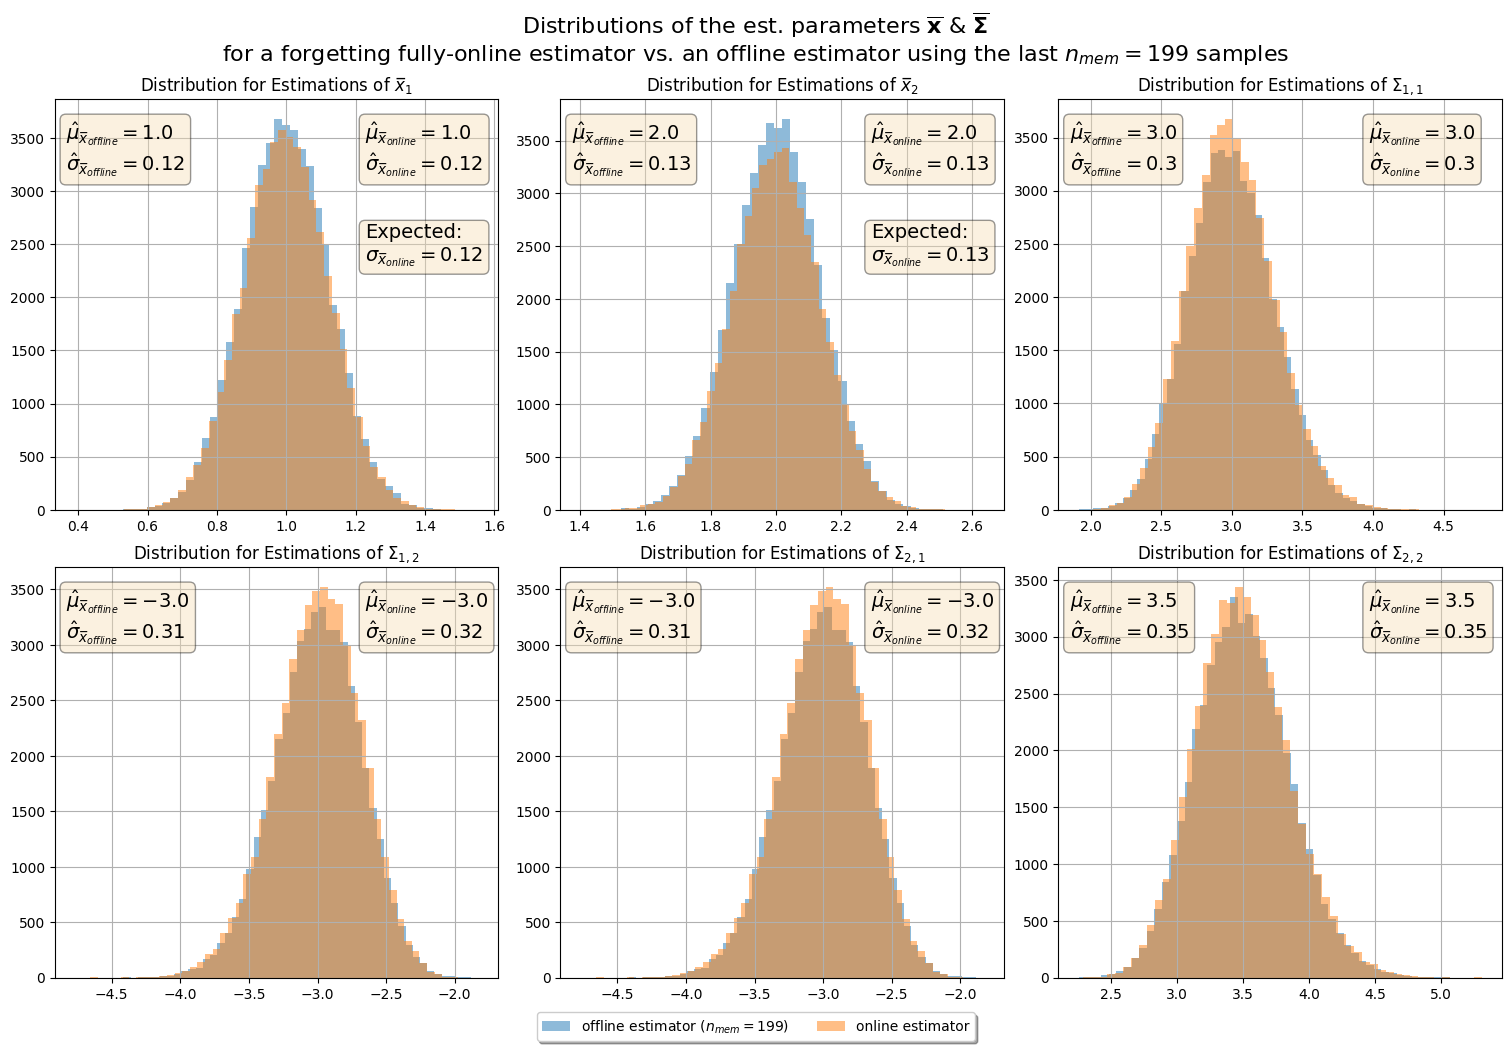

In [450]:
# --- Compare online vs. offline estimators: parameter distributions ---
fig, axs = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

# Loop over each estimated parameter (mean components + covariance elements)
for idx in range(all_experiments.shape[-1]):
    ax_row = idx // 3
    ax_col = idx % 3
    ax = axs[ax_row, ax_col]

    # Extract offline ("real") vs. online estimates across experiments
    reals = all_experiments[:, 1, idx]    # offline/batch reference
    onlines = all_experiments[:, 0, idx]  # online estimates

    # Plot histograms (only label once to avoid duplicate legend entries)
    ax.hist(
        reals,
        label="offline estimator ($n_{mem}=" + str(round(n_mem)) + "$)" if idx < 1 else None,
        bins=50,
        alpha=0.5,
    )
    ax.hist(
        onlines,
        label="online estimator" if idx < 1 else None,
        bins=50,
        alpha=0.5,
    )

    # --- Annotate offline estimator statistics (mean & std) ---
    mu, sigma = np.mean(reals), np.std(reals)
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.4)
    text_box_str = (
        "$\\hat{\\mu}_{x̅_{offline}}=" + str(round(mu, 2)) + "$\n"
        + "$\\hat{\\sigma}_{x̅_{offline}}=" + str(round(sigma, 2)) + "$"
    )
    ax.text(0.025, 0.95, text_box_str, transform=ax.transAxes, fontsize=14,
            verticalalignment="top", bbox=props)

    # --- Annotate online estimator statistics (mean & std) ---
    mu, sigma = np.mean(onlines), np.std(onlines)
    text_box_str = (
        "$\\hat{\\mu}_{x̅_{online}}=" + str(round(mu, 2)) + "$\n"
        + "$\\hat{\\sigma}_{x̅_{online}}=" + str(round(sigma, 2)) + "$"
    )
    ax.text(0.7, 0.95, text_box_str, transform=ax.transAxes, fontsize=14,
            verticalalignment="top", bbox=props)

    # --- Add theoretical expected variance of online mean (only for mean components) ---
    if idx < 2:
        std = np.sqrt(expected_Sigma_mean[idx, idx])
        text_box_str = "Expected:\n" + "$\\sigma_{x̅_{online}}=" + str(round(sigma, 2)) + "$"
        ax.text(0.7, 0.7, text_box_str, transform=ax.transAxes, fontsize=14,
                verticalalignment="top", bbox=props)

    # Title for each subplot (parameter being estimated)
    ax.set_title(f"Distribution for Estimations of {elem_names[idx]}")
    ax.grid()

# --- Shared legend across subplots ---
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.0),
           fancybox=True, shadow=True, ncol=2)

# --- Global title ---
fig.suptitle(
    "Distributions of the est. parameters $\\mathbf{\\overline{x}}$ & $\\mathbf{\\overline{\\Sigma}}$\n"
    "for a forgetting fully-online estimator vs. an offline estimator using the last "
    f"$n_{{mem}}={round(n_mem)}$ samples",
    fontsize=16,
)

# Display plots
plt.show(fig)


### Results when (wrongly) assuming that $n_{mem}=100$

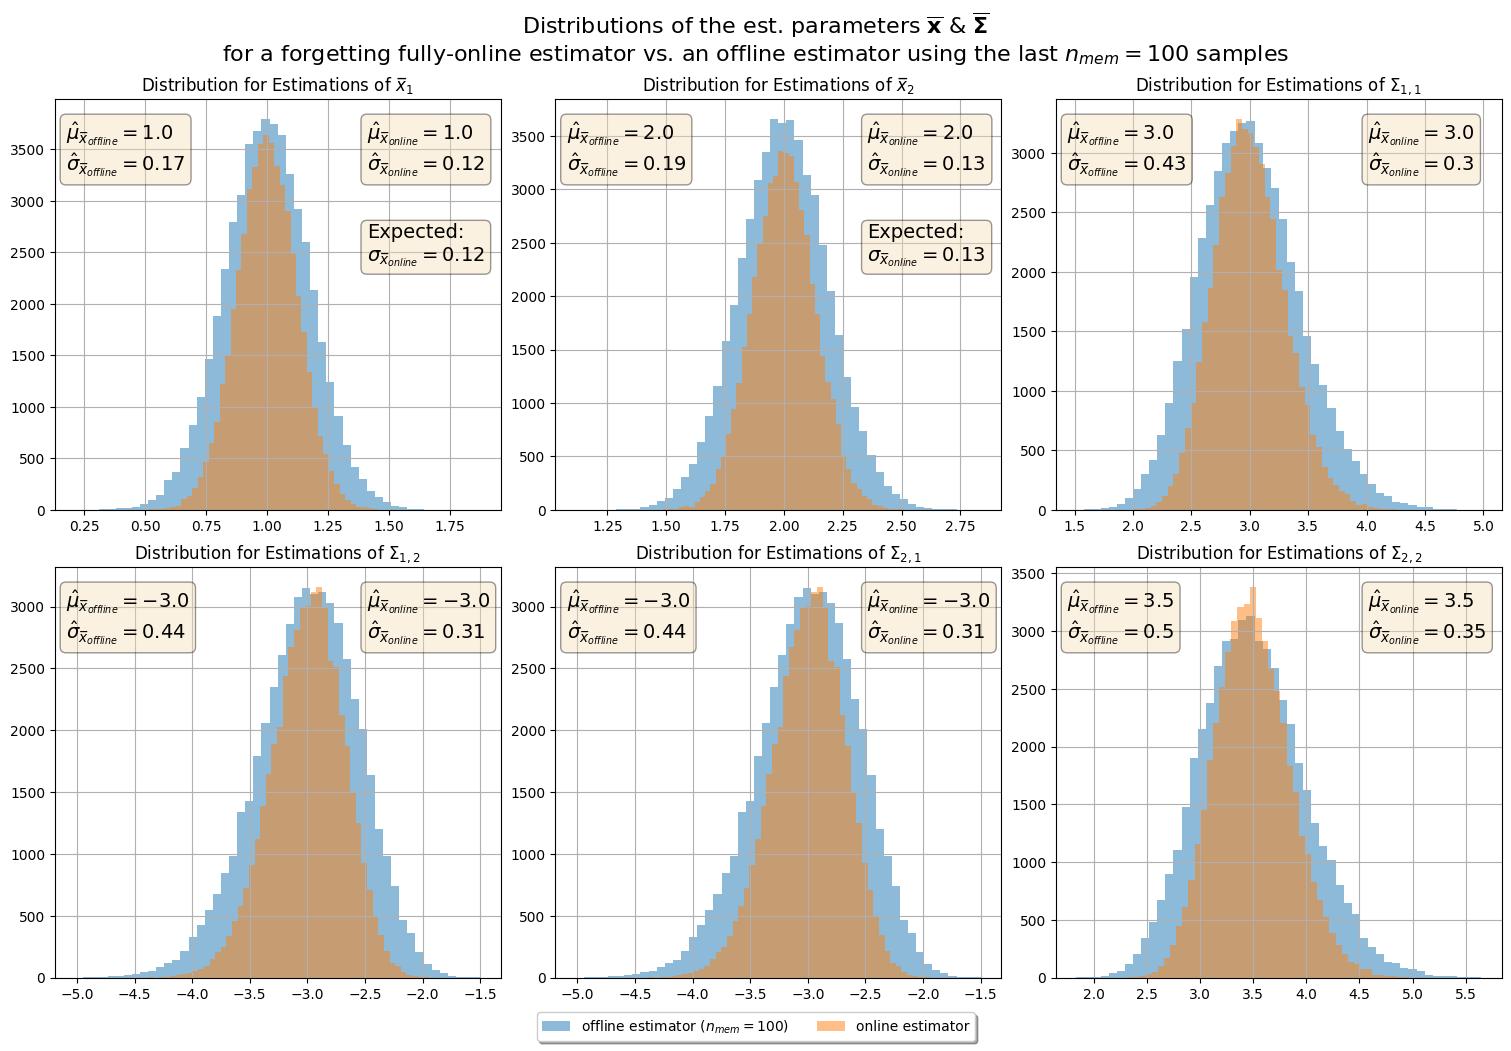

### Results when assuming that $n_{mem}=\frac{1+\lambda}{1-\lambda}$

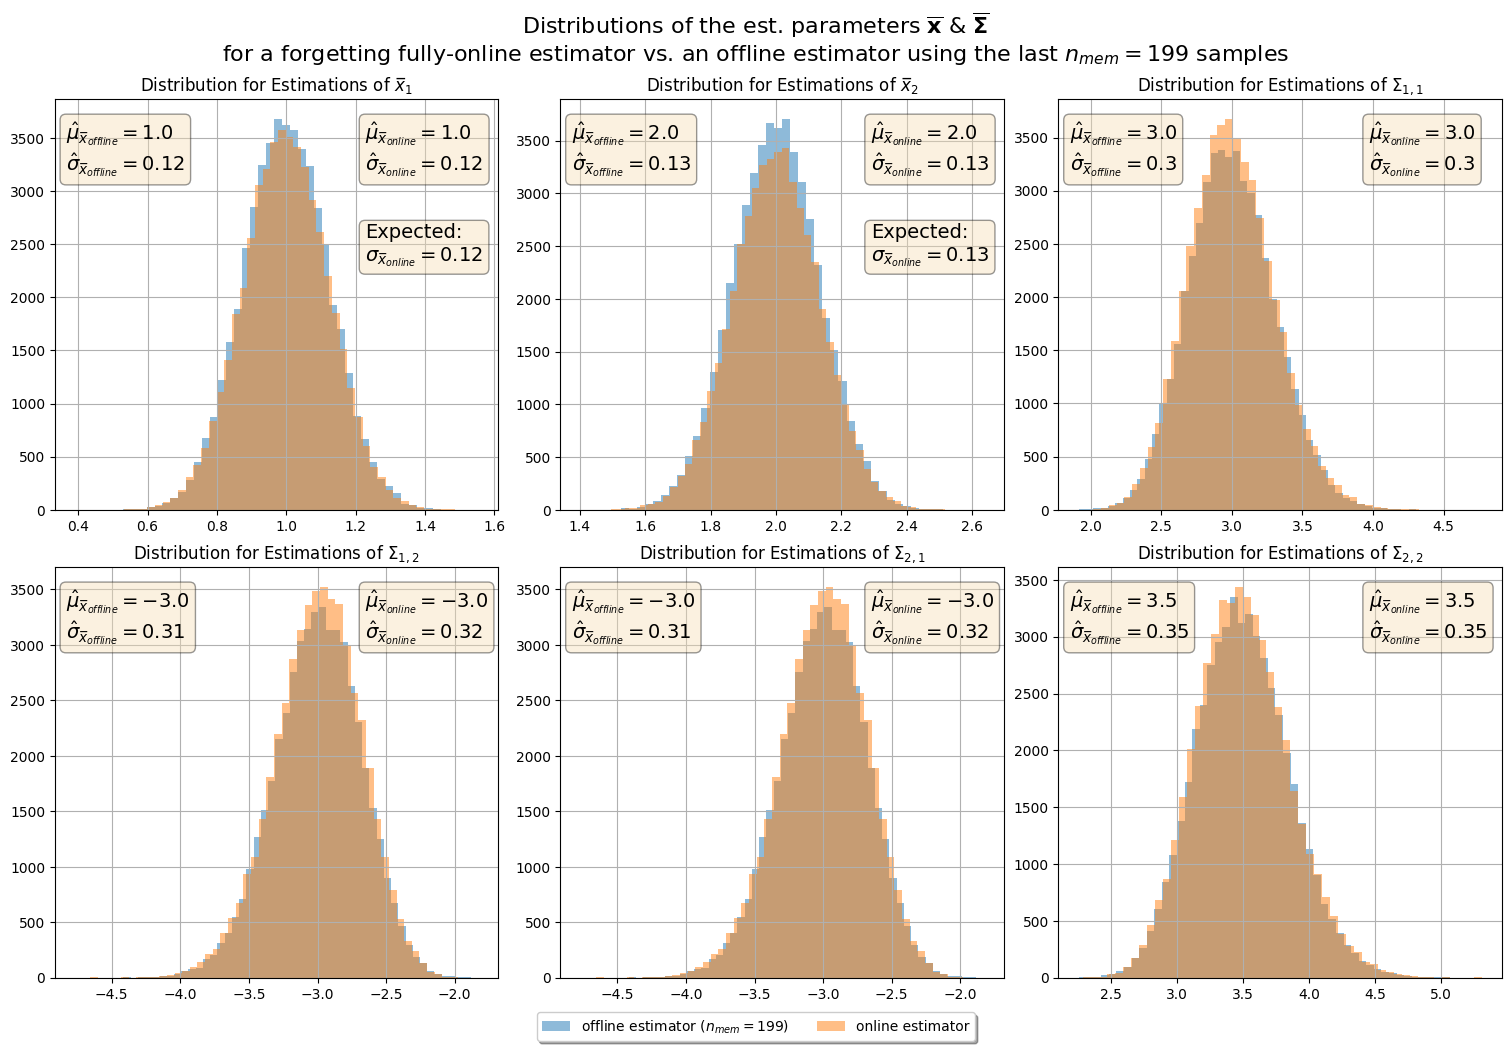